In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

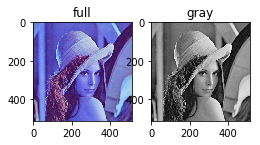

In [3]:
originImage = cv2.imread("../lena.jpg")
grayImage = cv2.cvtColor(originImage,cv2.COLOR_BGR2GRAY)
originImage32x32 = cv2.imread("../lena_32x32.jpg")
grayImage32x32 = cv2.cvtColor(originImage32x32,cv2.COLOR_BGR2GRAY)
plt.subplot(1, 3, 1)
plt.title("full")
plt.imshow(originImage)
plt.subplot(1, 3, 2)
plt.title("gray")
plt.gray()
plt.imshow(grayImage)

In [24]:
def show_img(src,desc,r,c,Iid):
    plt.subplot(r, c, Iid)
    plt.title(desc)
    plt.imshow(src)


In [47]:
# full类型卷积操作.
#
# ax,ay: anchor's location

def conv2d_same(src,kernel,ax,ay,stride):
    kw,kh=kernel.shape
    iwo,iho=src.shape
    r=int(kw/2)
    dst=src.copy()
    dst_full=np.pad(dst,((r,r),(r,r)),constant_values=(0,0),mode='constant') # 扩充2r个0
    dest = dst_full.copy()
    i=j=r
    iw,ih=dest.shape
    #print("r:%d,iw:%d,ih:%d,pad_iw:%d,pad_ih:%d" %(r,iwo,iho,iw,ih))

    if kw%2==1:
        odds=1
    else:
        odds=0
    print("i:%d,iw:%d,ih:%d,r:%d,odds:%d" %(i,iw,ih,r,odds))
    sax=ax
    say=ay
    while i< (iw+2*r-r-odds-1):
        while j<(ih+2*r-r-odds-1):
            temp=kernel*dst_full[(i-r):(i+r+odds),(j-r):(j+r+odds)]
            #print("[i:%d,j:%d]origin dest[%d,%d]:%d" %(i,j,ax,ay,dest[ax,ay]))
            dest[ax,ay]=np.sum(temp)
            #print("[i:%d,j:%d]after dest[%d,%d]:%d" %(i,j,ax,ay,dest[ax,ay]))
            j+=stride
            ay+=stride
        i+=stride
        ax+=stride
        j=r
        ay=say # 易忘记,参数的回归,迭代,更新.

    return dest

def conv1d_same(src,kernel,ax,ay,stride):
    kw,kh=kernel.shape
    if kw<=1 and kh <=1:
        print("wrong kernel size")
        return 
    if kh==1: # 一行n列的kernel,按行卷积
        r=int(kw/2)
        dst=src.copy()
        dst_full=np.pad(dst,((r,r),(0,0)),constant_values=(0,0),mode='constant') # 扩充2r个0
        dest = dst_full.copy()
        iw,ih=dest.shape
        #odds=(kw%2==1)?1:0
        if kw%2==1:
            odds=1
        else:
            odds=0
        while i<iw+2*r-r-odds-1:
            while j<ih-1:
                temp=kernel*dst_full[(i-r):(i+r+odds),j]
                dest[ax,ay]=np.sum(temp)
                ax+=stride
                i+=stride
            j+=1
            ay+=1 # 很容易就忘记了迭代
    elif kw==1:# n行一列
        r=int(kh/2)
        dst=src.copy()
        dst_full=np.pad(dst,((0,0),(r,r)),constant_values=(0,0),mode='constant') # 扩充2r个0
        dest = dst_full.copy()
        iw,ih=dest.shape
        #odds=(kh%2==1)?1:0
        if kh%2==1:
            odds=1
        else:
            odds=0
        while i<iw-1:
            while j<ih+2*r-r-odds-1:
                temp=kernel*dst_full[i,(j-r):(j+r+odds)]
                dest[ax,ay]=np.sum(temp)
                ay+=stride
                j+=stride
            i+=1
            ax+=1
    
    return dest

i:1,iw:514,ih:514,r:1,odds:0
i:1,iw:514,ih:514,r:1,odds:0


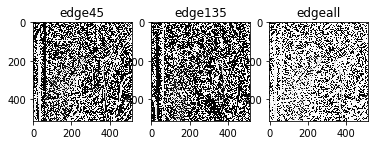

In [48]:
def roberts_edge(src):
    # 生成两个roberts算子
    R1=np.array([[1,0],[0,-1]],np.float32)
    R2=np.array([[0,1],[-1,0]],np.float32)
    IconR1=conv2d_same(src,R1,0,0,stride=1)
    IconR2=conv2d_same(src,R2,0,1,stride=1)
    IconR1=np.abs(IconR1)
    IconR1=IconR1.astype(np.uint8)
    IconR2=np.abs(IconR2)
    IconR2=IconR2.astype(np.uint8)
    show_img(IconR1,"edge45",1,3,1)
    show_img(IconR2,"edge135",1,3,2)
    #cv2.imshow("edge45",IconR1)
    #cv2.imshow("edge135",IconR2)
    edge_all=np.sqrt(np.power(IconR1,2.0)+np.power(IconR2,2.0))
    edge_all=np.round(edge_all)
    edge_all[edge_all>255]=255
    edge_all=edge_all.astype(np.uint8)
    show_img(edge_all,"edgeall",1,3,3)
    #cv2.imshow("edgeall",edge_all)

roberts_edge(grayImage)

#### prewitt算子

可分离卷积核.
![prewitt算子](https://gss2.bdstatic.com/-fo3dSag_xI4khGkpoWK1HF6hhy/baike/c0%3Dbaike72%2C5%2C5%2C72%2C24/sign=cb3bb6b043166d222c7a1dc6274a6292/ca1349540923dd54c88e9613d109b3de9d8248cf.jpg)

In [ ]:
def prewitt(src):
    # 垂直方向平滑,水平方向差分